# Predicting Vaccination: Modeling H1N1

Analysis by Corey Hanson & Frank Flavell

![](img/pred_vacc_model_h1n1.png)

# Business Case

The U.S. Department of Health & Human Services alomg with the National Center for Health Statistics launched a national telephone survey to gather data from a sample of the U.S. population in order to make predictions about H1N1 and Seasonal Flu vaccinations.

**Target:**
  * H1N1 Vaccination: Did the survey respondant receive the vaccine or not?
  * Seasonal Flue Vaccination: Did the survey respondant receive the vaccine or not?

We have been tasked with developing a classification model to make the predictions based on the survey results.  The specific end goal has not yet been determined, as this information may have many different uses in policy making, business, and non-profit health work.  Therefore, we are keeping an open mind when modeling to determine a few different possible models that would be appropriate in different contexts.

The survey data can be found at this link: [National 2009 H1N1 Survey](https://www.drivendata.org/competitions/66/flu-shot-learning/page/210/)

## Table of Contents<span id="0"></span>

1. [**Train/ Test Split, Class Imbalance & Standardization**](#1)
    * User Defined Function for splitting, standardizing and correcting class imbalance
    * Train/test set relabeling
2. [**Logisitic Regression**](#2)
    * Baseline
    * Optimized Models
3. [**K-Nearest Neighbor**](#3)
    * Baseline
    * Determine Best K
    * Optimized Model
4. [**Decision Tree**](#4)
    * Baseline
    * Determine Best Depth
    * Optimized Model
5. [**Random Forest**](#5)
    * Baseline
    * GridSearch
    * Optimized Model
6. [**AdaBoost**](#6)
    * Baseline
    * GridSearch
    * Optimized Model
7. [**XGBoost**](#7)
    * Baseline
    * GridSearch
    * Optimized Models
8. [**Support Vector Machine**](#8)
    * Baseline
    * GridSearch
    * Optimized Models
9. [**Best Model**](#9)
    * Analysis
    * Recommendations
    

# Package Import

In [26]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import metrics
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score


import xgboost as xgb
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import TomekLinks


from cleaning_functions import *
from eda import *

from random_lumberjacks.src.random_lumberjacks.model.model_classes import *
from random_lumberjacks.src.random_lumberjacks.visualization.visualization_functions import *

warnings.filterwarnings('ignore')
%matplotlib inline

# Data Import and Review

In [2]:
df = pd.read_pickle('data.pickle')

In [3]:
pd.set_option('display.max_columns', None)
df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,homeowner,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine,missing_doctor_recc,missing_health_insurance,missing_homeowner,missing_household,missing_opinion,missing_demographics
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55_to_64 Years,< 12 Years,White,Female,Below Poverty,Not Married,1.0,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,unknown,unknown,0,0,0,0,0,0,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35_to_44 Years,12 Years,White,Male,Below Poverty,Not Married,0.0,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1,0,0,0,0,0,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,1.0,4.0,1.0,2.0,18_to_34 Years,College Graduate,White,Male,Above Poverty,Not Married,1.0,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0,1,1,0,0,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,3.0,5.0,5.0,4.0,1.0,Over_65,12 Years,White,Female,Below Poverty,Not Married,0.0,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,unknown,unknown,0,1,0,1,0,0,0,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,2.0,3.0,1.0,4.0,45_to_54 Years,Some College,White,Female,Above Poverty,Married,1.0,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0,0,1,0,0,0,0


In [4]:
df.shape

(26707, 43)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26707 non-null  float64
 1   h1n1_knowledge               26707 non-null  float64
 2   behavioral_antiviral_meds    26707 non-null  float64
 3   behavioral_avoidance         26707 non-null  float64
 4   behavioral_face_mask         26707 non-null  float64
 5   behavioral_wash_hands        26707 non-null  float64
 6   behavioral_large_gatherings  26707 non-null  float64
 7   behavioral_outside_home      26707 non-null  float64
 8   behavioral_touch_face        26707 non-null  float64
 9   doctor_recc_h1n1             26707 non-null  float64
 10  doctor_recc_seasonal         26707 non-null  float64
 11  chronic_med_condition        26707 non-null  float64
 12  child_under_6_months         26707 non-null  float64
 13  health_worker   

In [6]:
df.describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,homeowner,household_adults,household_children,h1n1_vaccine,seasonal_vaccine,missing_doctor_recc,missing_health_insurance,missing_homeowner,missing_household,missing_opinion,missing_demographics
count,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000
mean,1.619800,1.261392,0.048714,0.727749,0.068933,0.825888,0.357472,0.336279,0.678811,0.202494,0.303067,0.272962,0.080054,0.108548,0.934998,3.852810,2.337589,2.352380,4.025536,2.705321,2.115737,0.777998,0.887558,0.529599,0.212454,0.465608,0.080878,0.459580,0.076459,0.009323,0.026398,0.065114
std,0.909016,0.617047,0.215273,0.445127,0.253345,0.379213,0.479264,0.472444,0.466942,0.401866,0.459592,0.445490,0.271382,0.311077,0.246533,1.000195,1.276825,1.353339,1.077131,1.375216,1.319585,0.415600,0.749980,0.925264,0.409052,0.498825,0.272652,0.498373,0.265737,0.096108,0.160318,0.246732
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,5.000000,4.000000,4.000000,5.000000,4.000000,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# <span id="1"></span>1. Train/ Test Split, Class Imbalance & Standardization
#### [Return Contents](#0)
<hr/>

During EDA, we determined that there was a class imblance for the H1N1 Vaccination target variable.  To correct this imbalance, we downsampled the majority class so that our models would run faster during training.

The user-defined class below creates an object, 'data', that houses the original dataframe as well as any transformations we added including dummy variables, scaling, class imbalance correction and ploynomial features.  It also takes care of the train/test split.

In [4]:
#Creating column selection dictionaries for the data from lists of column names.

#Lists to go in the dictionaries.
binary_columns = ['behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'homeowner']
missing_dummies = extract_column_names(df, "^missing")
target_col1 = "h1n1_vaccine"
target_col2 = "seasonal_vaccine"
target_cols = [target_col1, target_col2]
untr = ['household_adults', 'household_children',]
nom = df.columns.drop([*untr, *binary_columns, *target_cols, *missing_dummies])

#The dicts that come into the arguments.
categorical = {
    "nominal_features":nom, "standard_dummies": binary_columns, "impute_dummies":missing_dummies
}

continuous = {"untransformed":untr}
polynomial = {"method":"choose", "columns":['age_group', 'education', 'sex',
                                            'doctor_recc_seasonal', 'income_poverty']}

In [5]:
#creates a downsampled object storing the data with no scaling or interactions.
unscaled = DataPreprocessor(df, target_col1, categorical, continuous, polynomial, True, True,random_state=124)
unscaled.data_preprocessing(balance_class='downsample', scale_type=False)

#creates a downsampled object storing the data with scaling and no interactions.
scaled = DataPreprocessor(df, target_col1, categorical, continuous, polynomial, True, True,random_state=124)
scaled.data_preprocessing(balance_class='downsample', scale_type="standard")

#creates a downsampled object storing the data with scaling and no interactions and minimizes features.
select_features = ['doctor_recc_h1n1', 'opinion_h1n1_vacc_effective_5.0', 'missing_health_insurance', 'opinion_h1n1_risk_4.0',
                   'opinion_h1n1_risk_5.0', 'household_adults', 'health_worker', 'marital_status_Not Married']
reduced = DataPreprocessor(df, target_col1, categorical, continuous, polynomial, True, True,random_state=124)
reduced.data_preprocessing(balance_class='downsample', scale_type="standard")
reduced.column_drop(reduced.cols)
reduced.column_drop(select_features, reverse=True)

#creates a downsampled object storing the data with scaling select interactions.
interactions = DataPreprocessor(df, target_col1, categorical, continuous, polynomial, True, True,random_state=124)
interactions.data_preprocessing(balance_class='downsample', scale_type="standard", poly_degree=2)
interactions.column_drop(interactions.cols_polynomial)
interactions.column_drop(['doctor_recc_seasonal education_Some College',
                  'doctor_recc_seasonal sex_Male'], reverse=True)
interactions.get_df()

Creating Dummies
Skipping polynomial features
Performing downsample
No scaling specified
Skipping scaling
Creating Dummies
Skipping polynomial features
Performing downsample
Using standard scaler
Creating Dummies
Skipping polynomial features
Performing downsample
Using standard scaler
Adding ['household_adults', 'household_children', 'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance', 'homeowner', 'missing_doctor_recc', 'missing_health_insurance', 'missing_homeowner', 'missing_household', 'missing_opinion', 'missing_demographics', 'h1n1_concern_1.0', 'h1n1_concern_2.0', 'h1n1_concern_3.0', 'h1n1_knowledge_1.0', 'h1n1_knowledge_2.0', 'opinion_h1n1_vacc_effective_2.0', 'opinion_h1n1_vacc_effective_3.0', 'opinion_h1n1_vacc_effecti

,household_adults,household_children,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,homeowner,missing_doctor_recc,missing_health_insurance,missing_homeowner,missing_household,missing_opinion,missing_demographics,h1n1_concern_1.0,h1n1_concern_2.0,h1n1_concern_3.0,h1n1_knowledge_1.0,h1n1_knowledge_2.0,opinion_h1n1_vacc_effective_2.0,opinion_h1n1_vacc_effective_3.0,opinion_h1n1_vacc_effective_4.0,opinion_h1n1_vacc_effective_5.0,opinion_h1n1_risk_2.0,opinion_h1n1_risk_3.0,opinion_h1n1_risk_4.0,opinion_h1n1_risk_5.0,opinion_h1n1_sick_from_vacc_2.0,opinion_h1n1_sick_from_vacc_3.0,opinion_h1n1_sick_from_vacc_4.0,opinion_h1n1_sick_from_vacc_5.0,opinion_seas_vacc_effective_2.0,opinion_seas_vacc_effective_3.0,opinion_seas_vacc_effective_4.0,opinion_seas_vacc_effective_5.0,opinion_seas_risk_2.0,opinion_seas_risk_3.0,opinion_seas_risk_4.0,opinion_seas_risk_5.0,opinion_seas_sick_from_vacc_2.0,opinion_seas_sick_from_vacc_3.0,opinion_seas_sick_from_vacc_4.0,opinion_seas_sick_from_vacc_5.0,age_group_35_to_44 Years,age_group_45_to_54 Years,age_group_55_to_64 Years,age_group_Over_65,education_< 12 Years,education_College Graduate,education_Some College,race_Hispanic,race_Other or Multiple,race_White,sex_Male,income_poverty_Above Poverty,income_poverty_Below Poverty,income_poverty_unknown,marital_status_Not Married,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Principle City",census_msa_Non-MSA,employment_industry_atmlpfrs,employment_industry_cfqqtusy,employment_industry_dotnnunm,employment_industry_fcxhlnwr,employment_industry_haxffmxo,employment_industry_ldnlellj,employment_industry_mcubkhph,employment_industry_mfikgejo,employment_industry_msuufmds,employment_industry_nduyfdeo,employment_industry_phxvnwax,employment_industry_pxcmvdjn,employment_industry_qnlwzans,employment_industry_rucpziij,employment_industry_saaquncn,employment_industry_unknown,employment_industry_vjjrobsf,employment_industry_wlfvacwt,employment_industry_wxleyezf,employment_industry_xicduogh,employment_industry_xqicxuve,employment_occupation_ccgxvspp,employment_occupation_cmhcxjea,employment_occupation_dcjcmpih,employment_occupation_dlvbwzss,employment_occupation_emcorrxb,employment_occupation_haliazsg,employment_occupation_hfxkjkmi,employment_occupation_hodpvpew,employment_occupation_kldqjyjy,employment_occupation_mxkfnird,employment_occupation_oijqvulv,employment_occupation_pvmttkik,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_unknown,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv,doctor_recc_seasonal education_Some College,doctor_recc_seasonal sex_Male,h1n1_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12299,0.144861,-0.566274,4.170946,0.582046,-0.304298,0.426347,-0.759815,-0.722939,0.654314,1.460150,1.289945,-0.660262,-0.323563,2.431594,-4.110321,0.508496,-0.260173,-0.788248,-0.283740,-0.091367,-0.153752,-0.258738,-0.630117,-0.834217,2.005463,0.965097,-0.805423,-0.228625,-0.412158,-0.861933,1.346931,-0.750922,-0.202322,1.683623,-0.336953,-0.714225,-0.069398,-0.551173,3.094517,-0.261602,-0.198796,-0.865008,1.137981,-0.692080,-0.170728,-0.696388,2.430524,-0.646513,-0.049013,-0.473631,3.795087,2.554328,-0.480513,-0.539910,-0.601175,-0.293704,-0.897984,1.675103,-0.27

DataFrame with the dummy variables and the downsample class imblanace correction.

## Instantiating the Evaluation DataFrame

In [6]:
evaluation = pd.DataFrame({'Model': [],
                           'Details':[],
                           'Accuracy':[],
                           'Precision':[],
                           'FP':[],
                           'Recall':[],
                           'FN':[],
                           'F1-Score':[],
                           'AUC':[]})

# <span id="2"></span>2. Logistic Regression
#### [Return Contents](#0)
<hr/>

## Logistic Regression Baseline

In [7]:
def evaluate_to_df(model, X_test, y_test, eval_df, title, description):
    """Evaluates a model, updating a dataframe that stores the results."""
    
    # Predict on the test set
    y_pred = model.predict(X_test)

    cm = metrics.confusion_matrix(y_test, y_pred)
    print(f'{title}: {description}')
    print('Confusion Matrix :')
    print(cm)
    print('Test Accuracy Score :',metrics.accuracy_score(y_test, y_pred))
    print('Report : ')
    print(classification_report(y_test, y_pred))

    acc = float(format(metrics.accuracy_score(y_test, y_pred, sample_weight=None), '.3f'))
    prec = float(format(metrics.precision_score(y_test, y_pred),'.3f'))
    fp = cm[0,1]
    rec = float(format(metrics.recall_score(y_test, y_pred),'.3f'))
    fn = cm[1,0]
    auc = float(format(metrics.roc_auc_score(y_test, y_pred),'.3f'))
    f1 = float(format(metrics.f1_score(y_test, y_pred),'.3f'))

    r = eval_df.shape[0]
    eval_df.loc[r] = [title,description,acc,prec,fp,rec,fn,auc,f1]
    return eval_df.sort_values(by = 'AUC', ascending=False)

In [8]:
# Logisitic Regression 1: All Features, Not Scaled
logreg1 = LogisticRegression().fit(unscaled.get_X_train(), unscaled.y_train)

evaluate_to_df(logreg1, unscaled.get_X_test(), unscaled.y_test, evaluation, 'Logistic Regression-1', 'All Features, Not Scaled')

Logistic Regression-1: All Features, Not Scaled
Confusion Matrix :
[[3429  829]
 [ 265  819]]
Test Accuracy Score : 0.7952077873455634
Report : 
              precision    recall  f1-score   support

           0       0.93      0.81      0.86      4258
           1       0.50      0.76      0.60      1084

    accuracy                           0.80      5342
   macro avg       0.71      0.78      0.73      5342
weighted avg       0.84      0.80      0.81      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
0,Logistic Regression-1,"All Features, Not Scaled",0.795,0.497,829.0,0.756,265.0,0.78,0.6


## Logistic Regression Optimizations

In [9]:
# Logisitic Regression 2: All Features, Scaled
logreg2 = LogisticRegression().fit(scaled.get_X_train(), scaled.y_train)
evaluate_to_df(logreg2, scaled.get_X_test(), scaled.y_test, evaluation, 'Logistic Regression-2', 'All Features, Scaled')

#---------------------------------------------------------------------------------------------

#Logistic Regression: Select Features, Scaled
logreg3 = LogisticRegression().fit(reduced.get_X_train(), reduced.y_train)
evaluate_to_df(logreg3, reduced.get_X_test(), reduced.y_test, evaluation, 'Logistic Regression-3', 'Select Features, Scaled')

#---------------------------------------------------------------------------------------------

#Logistic Regression: Select Features, Scaled, with Interactions
logreg4 = LogisticRegression().fit(interactions.get_X_train(), interactions.y_train)
evaluate_to_df(logreg4, interactions.get_X_test(), interactions.y_test, evaluation, 'Logistic Regression-4', 'All Features, Scaled, with Interactions')

Logistic Regression-2: All Features, Scaled
Confusion Matrix :
[[3427  831]
 [ 266  818]]
Test Accuracy Score : 0.7946461999251216
Report : 
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      4258
           1       0.50      0.75      0.60      1084

    accuracy                           0.79      5342
   macro avg       0.71      0.78      0.73      5342
weighted avg       0.84      0.79      0.81      5342

Logistic Regression-3: Select Features, Scaled
Confusion Matrix :
[[3357  901]
 [ 281  803]]
Test Accuracy Score : 0.7787345563459378
Report : 
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      4258
           1       0.47      0.74      0.58      1084

    accuracy                           0.78      5342
   macro avg       0.70      0.76      0.71      5342
weighted avg       0.83      0.78      0.79      5342

Logistic Regression-4: All Features, Scaled, with Interaction

,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"All Features, Not Scaled",0.795,0.497,829.0,0.756,265.0,0.780,0.600
1,Logistic Regression-2,"All Features, Scaled",0.795,0.496,831.0,0.755,266.0,0.780,0.599
2,Logistic Regression-3,"Select Features, Scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576


# <span id="3"></span>3. K-Nearest Neighbor (K-NN)
#### [Return Contents](#0)
<hr/>

## Baseline K-NN

In [10]:
# Instantiate KNeighborsClassifier
knn1 = KNeighborsClassifier()
# Fit the classifier
knn1.fit(interactions.get_X_train(), interactions.y_train)

evaluate_to_df(knn1, interactions.get_X_test(), interactions.y_test, evaluation, 'K-Nearest Neighbor', 'Baseline K=1')

K-Nearest Neighbor: Baseline K=1
Confusion Matrix :
[[2875 1383]
 [ 369  715]]
Test Accuracy Score : 0.6720329464619993
Report : 
              precision    recall  f1-score   support

           0       0.89      0.68      0.77      4258
           1       0.34      0.66      0.45      1084

    accuracy                           0.67      5342
   macro avg       0.61      0.67      0.61      5342
weighted avg       0.78      0.67      0.70      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"All Features, Not Scaled",0.795,0.497,829.0,0.756,265.0,0.780,0.600
1,Logistic Regression-2,"All Features, Scaled",0.795,0.496,831.0,0.755,266.0,0.780,0.599
2,Logistic Regression-3,"Select Features, Scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
4,K-Nearest Neighbor,Baseline K=1,0.672,0.341,1383.0,0.660,369.0,0.667,0.449


## KNN Optimization

In [11]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = metrics.f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

In [13]:
find_best_k(interactions.get_X_train(), interactions.y_train, interactions.get_X_test(), interactions.y_test, min_k=1, max_k=11)

Best Value for k: 9
F1-Score: 0.47028423772609823


In [15]:
# search for an optimal value of K for KNN
k_range = list(range(1, 11))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(interactions.get_X_train(), interactions.y_train)
    y_predict = knn.predict(interactions.get_X_test())
    score = metrics.f1_score(interactions.y_test, y_predict, average='weighted')
    k_scores.append(score)
print(k_scores)

[0.6557597159964801, 0.7507862336410064, 0.6932952855612802, 0.7532837166402875, 0.7021245055091099, 0.7494712766400834, 0.7156547495731275, 0.7483425710451154, 0.7202365132357981, 0.7465399674537562]


## KNN Optimized, K = 9

In [12]:
# Instantiate KNeighborsClassifier
knn2 = KNeighborsClassifier(n_neighbors=9)
# Fit the classifier
knn2.fit(interactions.get_X_train(), interactions.y_train)

evaluate_to_df(knn2, interactions.get_X_test(), interactions.y_test, evaluation, 'K-Nearest Neighbor', 'Optimized K=9')

K-Nearest Neighbor: Optimized K=9
Confusion Matrix :
[[2974 1284]
 [ 356  728]]
Test Accuracy Score : 0.6929988768251591
Report : 
              precision    recall  f1-score   support

           0       0.89      0.70      0.78      4258
           1       0.36      0.67      0.47      1084

    accuracy                           0.69      5342
   macro avg       0.63      0.69      0.63      5342
weighted avg       0.79      0.69      0.72      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"All Features, Not Scaled",0.795,0.497,829.0,0.756,265.0,0.780,0.600
1,Logistic Regression-2,"All Features, Scaled",0.795,0.496,831.0,0.755,266.0,0.780,0.599
2,Logistic Regression-3,"Select Features, Scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
5,K-Nearest Neighbor,Optimized K=9,0.693,0.362,1284.0,0.672,356.0,0.685,0.470
4,K-Nearest Neighbor,Baseline K=1,0.672,0.341,1383.0,0.660,369.0,0.667,0.449


# <span id="4"></span>4. Decision Tree
#### [Return Contents](#0)
<hr/>

## Decision Tree Baseline

In [13]:
# Instantiate and fit a DecisionTreeClassifier
dt1 = DecisionTreeClassifier(criterion='gini')

# fit the model
dt1.fit(interactions.get_X_train(), interactions.y_train)

evaluate_to_df(dt1, interactions.get_X_test(), interactions.y_test, evaluation, 'Decision Tree-1', 'Baseline')

Decision Tree-1: Baseline
Confusion Matrix :
[[2813 1445]
 [ 294  790]]
Test Accuracy Score : 0.6744664919505803
Report : 
              precision    recall  f1-score   support

           0       0.91      0.66      0.76      4258
           1       0.35      0.73      0.48      1084

    accuracy                           0.67      5342
   macro avg       0.63      0.69      0.62      5342
weighted avg       0.79      0.67      0.71      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"All Features, Not Scaled",0.795,0.497,829.0,0.756,265.0,0.780,0.600
1,Logistic Regression-2,"All Features, Scaled",0.795,0.496,831.0,0.755,266.0,0.780,0.599
2,Logistic Regression-3,"Select Features, Scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
6,Decision Tree-1,Baseline,0.674,0.353,1445.0,0.729,294.0,0.695,0.476
5,K-Nearest Neighbor,Optimized K=9,0.693,0.362,1284.0,0.672,356.0,0.685,0.470
4,K-Nearest Neighbor,Baseline K=1,0.672,0.341,1383.0,0.660,369.0,0.667,0.449


## Determine Feature Importance

In [16]:
# Feature importance
importance = pd.DataFrame(dt1.feature_importances_, index=interactions.get_X_train().columns).reset_index().sort_values(by = 0, ascending=False)
importance.head(8).values

array([['doctor_recc_h1n1', 0.16969860861804767],
       ['opinion_h1n1_vacc_effective_5.0', 0.061120026142828895],
       ['missing_health_insurance', 0.05092901460582436],
       ['opinion_h1n1_risk_4.0', 0.026921519916768128],
       ['household_adults', 0.019049898883747595],
       ['opinion_h1n1_risk_5.0', 0.01725275300400127],
       ['health_worker', 0.016757923653604092],
       ['household_children', 0.015736398852394917]], dtype=object)

In [19]:
def show_feature_importances(model, df, figsize=(14, 12), palette=None, font_scale=1, ascending=False, rows=12, style="darkgrid"):
    sns.set_style(style)
    f, ax = plt.subplots(figsize=figsize)
    sns.set(font_scale=font_scale)
    importance = pd.DataFrame(model.feature_importances_, index=df.columns).reset_index()
    importance.columns = pd.Index(["Feature", "Importance"])
    sns.barplot(y="Feature", x="Importance", data=importance.sort_values("Importance",ascending=ascending).iloc[0:rows],
                palette=palette, ax=ax)

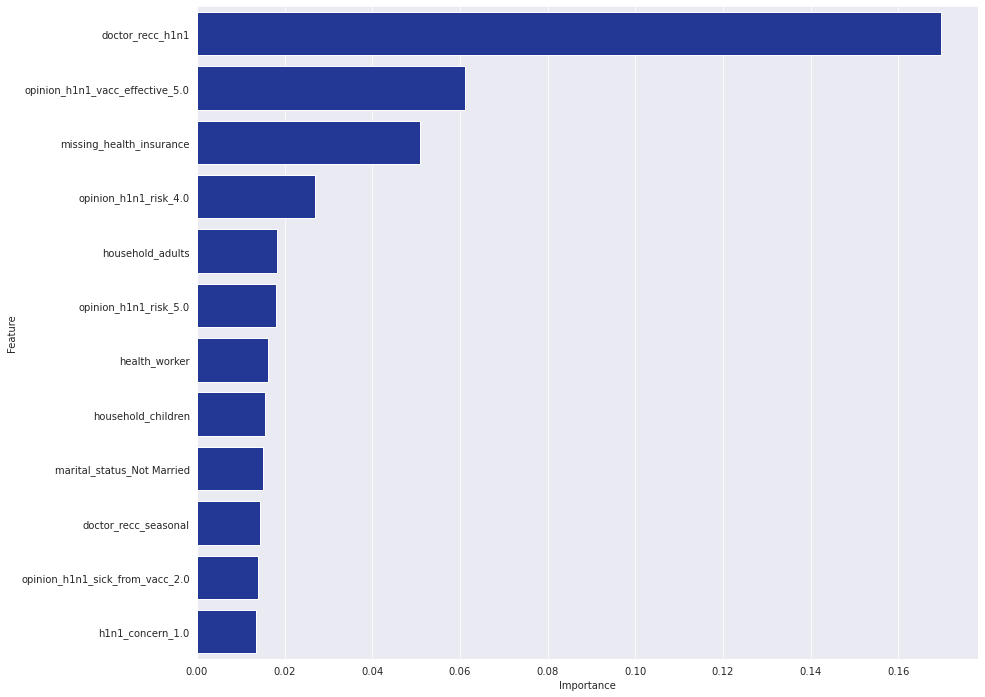

In [20]:
# Feature importance Graph
pal = sns.color_palette(("#102CA8",))
show_feature_importances(dt1, interactions.get_X_train(), figsize=(14, 12), palette=pal, font_scale=1, ascending=False, rows=12, style="darkgrid")


## Determine Ideal Depth

[0.6920479302832245, 0.7235294117647058, 0.7441176470588234, 0.7555555555555556, 0.7586056644880175, 0.7630718954248366, 0.7604575163398692, 0.7556644880174292, 0.7544662309368193]


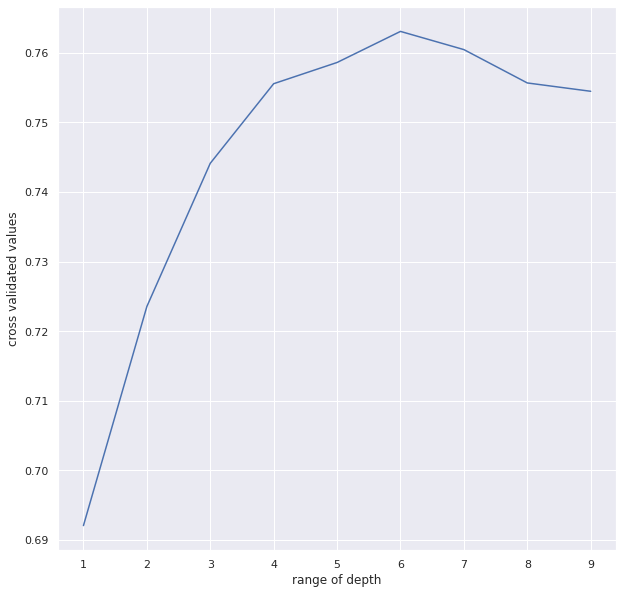

In [22]:
score = cross_val_score(dt1, interactions.get_X_train(), interactions.y_train, cv = 5)
score.mean()
depth_range = range(1,10)
val = []
for depth in depth_range:
    ctree = DecisionTreeClassifier(max_depth = depth)
    depth_score = cross_val_score(ctree, interactions.get_X_train(), interactions.y_train, cv = 5)
    val.append(depth_score.mean())
print(val)
plt.figure(figsize = (10,10))
plt.plot(depth_range, val)
plt.xlabel('range of depth')
plt.ylabel('cross validated values')
plt.show()

## Optimized Decision Tree: Depth 6

In [14]:
# Instantiate and fit a DecisionTreeClassifier
dt2 = DecisionTreeClassifier(criterion='gini', max_depth=6)

# fit the model
dt2.fit(interactions.get_X_train(), interactions.y_train)

evaluate_to_df(dt2, interactions.get_X_test(), interactions.y_test, evaluation, 'Decision Tree-2', 'Optimized: Depth 6')

Decision Tree-2: Optimized: Depth 6
Confusion Matrix :
[[3327  931]
 [ 274  810]]
Test Accuracy Score : 0.7744290527892175
Report : 
              precision    recall  f1-score   support

           0       0.92      0.78      0.85      4258
           1       0.47      0.75      0.57      1084

    accuracy                           0.77      5342
   macro avg       0.69      0.76      0.71      5342
weighted avg       0.83      0.77      0.79      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"All Features, Not Scaled",0.795,0.497,829.0,0.756,265.0,0.780,0.600
1,Logistic Regression-2,"All Features, Scaled",0.795,0.496,831.0,0.755,266.0,0.780,0.599
2,Logistic Regression-3,"Select Features, Scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
7,Decision Tree-2,Optimized: Depth 6,0.774,0.465,931.0,0.747,274.0,0.764,0.573
6,Decision Tree-1,Baseline,0.674,0.353,1445.0,0.729,294.0,0.695,0.476
5,K-Nearest Neighbor,Optimized K=9,0.693,0.362,1284.0,0.672,356.0,0.685,0.470
4,K-Nearest Neighbor,Baseline K=1,0.672,0.341,1383.0,0.660,369.0,0.667,0.449


## Decision Tree: Depth 6 with Reduced Features

In [15]:

dt3 = DecisionTreeClassifier(criterion='gini', max_depth=6)

# fit the model
dt3.fit(reduced.get_X_train(), reduced.y_train)

evaluate_to_df(dt3, reduced.get_X_test(), reduced.y_test, evaluation, 'Decision Tree-3', 'Depth 6, Select Features')

Decision Tree-3: Depth 6, Select Features
Confusion Matrix :
[[3195 1063]
 [ 233  851]]
Test Accuracy Score : 0.7573942343691501
Report : 
              precision    recall  f1-score   support

           0       0.93      0.75      0.83      4258
           1       0.44      0.79      0.57      1084

    accuracy                           0.76      5342
   macro avg       0.69      0.77      0.70      5342
weighted avg       0.83      0.76      0.78      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"All Features, Not Scaled",0.795,0.497,829.0,0.756,265.0,0.780,0.600
1,Logistic Regression-2,"All Features, Scaled",0.795,0.496,831.0,0.755,266.0,0.780,0.599
2,Logistic Regression-3,"Select Features, Scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
7,Decision Tree-2,Optimized: Depth 6,0.774,0.465,931.0,0.747,274.0,0.764,0.573
8,Decision Tree-3,"Depth 6, Select Features",0.757,0.445,1063.0,0.785,233.0,0.768,0.568
6,Decision Tree-1,Baseline,0.674,0.353,1445.0,0.729,294.0,0.695,0.476
5,K-Nearest Neighbor,Optimized K=9,0.693,0.362,1284.0,0.672,356.0,0.685,0.470
4,K-Nearest Neighbor,Baseline K=1,0.672,0.341,1383.0,0.660,369.0,0.667,0.449


# <span id="5"></span>5. Random Forest
#### [Return Contents](#0)
<hr/>

## Baseline Random Forest

In [16]:
forest1 = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest1.fit(interactions.get_X_train(), interactions.y_train)

evaluate_to_df(forest1, interactions.get_X_test(), interactions.y_test, evaluation, 'Random Forest-1', '100 Est, Max Depth 5')

Random Forest-1: 100 Est, Max Depth 5
Confusion Matrix :
[[3330  928]
 [ 273  811]]
Test Accuracy Score : 0.7751778360164733
Report : 
              precision    recall  f1-score   support

           0       0.92      0.78      0.85      4258
           1       0.47      0.75      0.57      1084

    accuracy                           0.78      5342
   macro avg       0.70      0.77      0.71      5342
weighted avg       0.83      0.78      0.79      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"All Features, Not Scaled",0.795,0.497,829.0,0.756,265.0,0.780,0.600
1,Logistic Regression-2,"All Features, Scaled",0.795,0.496,831.0,0.755,266.0,0.780,0.599
2,Logistic Regression-3,"Select Features, Scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
9,Random Forest-1,"100 Est, Max Depth 5",0.775,0.466,928.0,0.748,273.0,0.765,0.575
7,Decision Tree-2,Optimized: Depth 6,0.774,0.465,931.0,0.747,274.0,0.764,0.573
8,Decision Tree-3,"Depth 6, Select Features",0.757,0.445,1063.0,0.785,233.0,0.768,0.568
6,Decision Tree-1,Baseline,0.674,0.353,1445.0,0.729,294.0,0.695,0.476
5,K-Nearest Neighbor,Optimized K=9,0.693,0.362,1284.0,0.672,356.0,0.685,0.470
4,K-Nearest Neighbor,Baseline K=1,0.672,0.341,1383.0,0.660,369.0,0.667,0.449


## Random Forest Optimization: GridSearch

In [21]:
param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [ 2, 5, 10],
    'min_samples_leaf': [2, 3, 5, 7]
}

#Instantiate the gridsearch object
rf_grid_search = GridSearchCV(forest1, param_grid, cv=3)

# Fit to the data
rf_grid_search.fit(interactions.get_X_train(), interactions.y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(max_depth=5),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 6, 10],
                         'min_samples_leaf': [2, 3, 5, 7],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 30, 100]})

In [23]:
rf_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

## Optimized Random Forest

In [17]:
forest2 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=2,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False)
forest2.fit(interactions.get_X_train(), interactions.y_train)

evaluate_to_df(forest2, interactions.get_X_test(), interactions.y_test, evaluation, 'Random Forest-2', 'Optimized Hyperparameters')

Random Forest-2: Optimized Hyperparameters
Confusion Matrix :
[[3247 1011]
 [ 233  851]]
Test Accuracy Score : 0.7671284163234744
Report : 
              precision    recall  f1-score   support

           0       0.93      0.76      0.84      4258
           1       0.46      0.79      0.58      1084

    accuracy                           0.77      5342
   macro avg       0.70      0.77      0.71      5342
weighted avg       0.84      0.77      0.79      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"All Features, Not Scaled",0.795,0.497,829.0,0.756,265.0,0.780,0.600
1,Logistic Regression-2,"All Features, Scaled",0.795,0.496,831.0,0.755,266.0,0.780,0.599
10,Random Forest-2,Optimized Hyperparameters,0.767,0.457,1011.0,0.785,233.0,0.774,0.578
2,Logistic Regression-3,"Select Features, Scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
9,Random Forest-1,"100 Est, Max Depth 5",0.775,0.466,928.0,0.748,273.0,0.765,0.575
7,Decision Tree-2,Optimized: Depth 6,0.774,0.465,931.0,0.747,274.0,0.764,0.573
8,Decision Tree-3,"Depth 6, Select Features",0.757,0.445,1063.0,0.785,233.0,0.768,0.568
6,Decision Tree-1,Baseline,0.674,0.353,1445.0,0.729,294.0,0.695,0.476
5,K-Nearest Neighbor,Optimized K=9,0.693,0.362,1284.0,0.672,356.0,0.685,0.470


# <span id="6"></span>6. AdaBoost
#### [Return Contents](#0)
<hr/>

## AdaBoost Baseline

In [18]:
adaboost_clf = AdaBoostClassifier(random_state=42)
ada1 = adaboost_clf.fit(interactions.get_X_train(), interactions.y_train)

evaluate_to_df(ada1, interactions.get_X_test(), interactions.y_test, evaluation, 'AdaBoost-1', 'Baseline')

AdaBoost-1: Baseline
Confusion Matrix :
[[3413  845]
 [ 267  817]]
Test Accuracy Score : 0.7918382628229128
Report : 
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      4258
           1       0.49      0.75      0.60      1084

    accuracy                           0.79      5342
   macro avg       0.71      0.78      0.73      5342
weighted avg       0.84      0.79      0.81      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"All Features, Not Scaled",0.795,0.497,829.0,0.756,265.0,0.780,0.600
1,Logistic Regression-2,"All Features, Scaled",0.795,0.496,831.0,0.755,266.0,0.780,0.599
11,AdaBoost-1,Baseline,0.792,0.492,845.0,0.754,267.0,0.778,0.595
10,Random Forest-2,Optimized Hyperparameters,0.767,0.457,1011.0,0.785,233.0,0.774,0.578
2,Logistic Regression-3,"Select Features, Scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
9,Random Forest-1,"100 Est, Max Depth 5",0.775,0.466,928.0,0.748,273.0,0.765,0.575
7,Decision Tree-2,Optimized: Depth 6,0.774,0.465,931.0,0.747,274.0,0.764,0.573
8,Decision Tree-3,"Depth 6, Select Features",0.757,0.445,1063.0,0.785,233.0,0.768,0.568
6,Decision Tree-1,Baseline,0.674,0.353,1445.0,0.729,294.0,0.695,0.476


## AdaBoost Optimization: GridSearch

In [29]:
param_grid = {
    "learning_rate": [0.1, 0.2],
    'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=5)],
    'n_estimators': [5, 30, 100, 250],
}

ada_clf = AdaBoostClassifier(random_state=42)
grid_ada = GridSearchCV(ada_clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_ada.fit(interactions.get_X_train(), interactions.y_train)

best_parameters = grid_ada.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_ada.predict(interactions.get_X_train())
val_preds = grid_ada.predict(interactions.get_X_test())
training_accuracy = accuracy_score(interactions.y_train, training_preds)
val_accuracy = accuracy_score(interactions.y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Grid Search found the following optimal parameters: 
base_estimator: DecisionTreeClassifier(max_depth=1)
learning_rate: 0.2
n_estimators: 250

Training Accuracy: 78.16%
Validation accuracy: 79.5%


## AdaBoost Optimized

In [19]:
adaboost_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), learning_rate=0.2, n_estimators=250, random_state=42)
ada2 = adaboost_clf.fit(interactions.get_X_train(), interactions.y_train)

evaluate_to_df(ada2, interactions.get_X_test(), interactions.y_test, evaluation, 'AdaBoost-2', 'Optimized')

AdaBoost-2: Optimized
Confusion Matrix :
[[3429  829]
 [ 266  818]]
Test Accuracy Score : 0.7950205915387495
Report : 
              precision    recall  f1-score   support

           0       0.93      0.81      0.86      4258
           1       0.50      0.75      0.60      1084

    accuracy                           0.80      5342
   macro avg       0.71      0.78      0.73      5342
weighted avg       0.84      0.80      0.81      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"All Features, Not Scaled",0.795,0.497,829.0,0.756,265.0,0.780,0.600
1,Logistic Regression-2,"All Features, Scaled",0.795,0.496,831.0,0.755,266.0,0.780,0.599
12,AdaBoost-2,Optimized,0.795,0.497,829.0,0.755,266.0,0.780,0.599
11,AdaBoost-1,Baseline,0.792,0.492,845.0,0.754,267.0,0.778,0.595
10,Random Forest-2,Optimized Hyperparameters,0.767,0.457,1011.0,0.785,233.0,0.774,0.578
2,Logistic Regression-3,"Select Features, Scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
9,Random Forest-1,"100 Est, Max Depth 5",0.775,0.466,928.0,0.748,273.0,0.765,0.575
7,Decision Tree-2,Optimized: Depth 6,0.774,0.465,931.0,0.747,274.0,0.764,0.573
8,Decision Tree-3,"Depth 6, Select Features",0.757,0.445,1063.0,0.785,233.0,0.768,0.568


# <span id="7"></span>7. XGBoost
#### [Return Contents](#0)
<hr/>

## XGBoost Baseline

In [20]:
X_train_scaled = interactions.get_X_train().rename(columns=lambda x: x.replace('<', '_'))
X_test_scaled = interactions.get_X_test().rename(columns=lambda x: x.replace('<', '_'))

In [21]:
clf1 = xgb.XGBClassifier()
clf1.fit(X_train_scaled, interactions.y_train)

evaluate_to_df(clf1, X_test_scaled, interactions.y_test, evaluation, 'XGBoosting-1', 'Baseline')

XGBoosting-1: Baseline
Confusion Matrix :
[[3314  944]
 [ 257  827]]
Test Accuracy Score : 0.7751778360164733
Report : 
              precision    recall  f1-score   support

           0       0.93      0.78      0.85      4258
           1       0.47      0.76      0.58      1084

    accuracy                           0.78      5342
   macro avg       0.70      0.77      0.71      5342
weighted avg       0.83      0.78      0.79      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"All Features, Not Scaled",0.795,0.497,829.0,0.756,265.0,0.780,0.600
1,Logistic Regression-2,"All Features, Scaled",0.795,0.496,831.0,0.755,266.0,0.780,0.599
12,AdaBoost-2,Optimized,0.795,0.497,829.0,0.755,266.0,0.780,0.599
11,AdaBoost-1,Baseline,0.792,0.492,845.0,0.754,267.0,0.778,0.595
13,XGBoosting-1,Baseline,0.775,0.467,944.0,0.763,257.0,0.771,0.579
10,Random Forest-2,Optimized Hyperparameters,0.767,0.457,1011.0,0.785,233.0,0.774,0.578
2,Logistic Regression-3,"Select Features, Scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
9,Random Forest-1,"100 Est, Max Depth 5",0.775,0.466,928.0,0.748,273.0,0.765,0.575
7,Decision Tree-2,Optimized: Depth 6,0.774,0.465,931.0,0.747,274.0,0.764,0.573


## XGBoost Optimization: GridSearch

In [38]:
param_grid = {'n_estimators':[100,300,500],
              'learning_rate':[0.1,0.5,0.01],
              'max_depth':[3,5,7],
              'colsample_bytree':[0.5,0.4,0.3],
              'min_child_weight':[1,2,3]
             }

clf_xg = xgb.XGBClassifier()
grid_clf = GridSearchCV(clf_xg, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train_scaled, interactions.y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train_scaled)
val_preds = grid_clf.predict(X_test_scaled)
training_accuracy = accuracy_score(interactions.y_train, training_preds)
val_accuracy = accuracy_score(interactions.y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Grid Search found the following optimal parameters: 
colsample_bytree: 0.4
learning_rate: 0.1
max_depth: 7
min_child_weight: 1
n_estimators: 300

Training Accuracy: 95.96%
Validation accuracy: 78.06%


## XGBoost Optimized

In [22]:
clf2 = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, n_estimators=300, min_child_weight=2, colsample_bytree=0.4)
clf2.fit(X_train_scaled, interactions.y_train)

evaluate_to_df(clf2, X_test_scaled, interactions.y_test, evaluation, 'XGBoosting-2', 'Optimized')

XGBoosting-2: Optimized
Confusion Matrix :
[[3325  933]
 [ 244  840]]
Test Accuracy Score : 0.7796705353800075
Report : 
              precision    recall  f1-score   support

           0       0.93      0.78      0.85      4258
           1       0.47      0.77      0.59      1084

    accuracy                           0.78      5342
   macro avg       0.70      0.78      0.72      5342
weighted avg       0.84      0.78      0.80      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"All Features, Not Scaled",0.795,0.497,829.0,0.756,265.0,0.780,0.600
1,Logistic Regression-2,"All Features, Scaled",0.795,0.496,831.0,0.755,266.0,0.780,0.599
12,AdaBoost-2,Optimized,0.795,0.497,829.0,0.755,266.0,0.780,0.599
11,AdaBoost-1,Baseline,0.792,0.492,845.0,0.754,267.0,0.778,0.595
14,XGBoosting-2,Optimized,0.780,0.474,933.0,0.775,244.0,0.778,0.588
13,XGBoosting-1,Baseline,0.775,0.467,944.0,0.763,257.0,0.771,0.579
10,Random Forest-2,Optimized Hyperparameters,0.767,0.457,1011.0,0.785,233.0,0.774,0.578
2,Logistic Regression-3,"Select Features, Scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
9,Random Forest-1,"100 Est, Max Depth 5",0.775,0.466,928.0,0.748,273.0,0.765,0.575


# <span id="8"></span>8. Support Vector Machine
#### [Return Contents](#0)
<hr/>

## Support Vector Machine Baseline

In [23]:
svc1 = SVC(kernel='poly', C=.01)  
svc1.fit(interactions.get_X_train(), interactions.y_train) 

evaluate_to_df(svc1, interactions.get_X_test(), interactions.y_test, evaluation, 'SVM', 'Poly, c=.01')

SVM: Poly, c=.01
Confusion Matrix :
[[4243   15]
 [1063   21]]
Test Accuracy Score : 0.7982029202545863
Report : 
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      4258
           1       0.58      0.02      0.04      1084

    accuracy                           0.80      5342
   macro avg       0.69      0.51      0.46      5342
weighted avg       0.76      0.80      0.71      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"All Features, Not Scaled",0.795,0.497,829.0,0.756,265.0,0.780,0.600
1,Logistic Regression-2,"All Features, Scaled",0.795,0.496,831.0,0.755,266.0,0.780,0.599
12,AdaBoost-2,Optimized,0.795,0.497,829.0,0.755,266.0,0.780,0.599
11,AdaBoost-1,Baseline,0.792,0.492,845.0,0.754,267.0,0.778,0.595
14,XGBoosting-2,Optimized,0.780,0.474,933.0,0.775,244.0,0.778,0.588
13,XGBoosting-1,Baseline,0.775,0.467,944.0,0.763,257.0,0.771,0.579
10,Random Forest-2,Optimized Hyperparameters,0.767,0.457,1011.0,0.785,233.0,0.774,0.578
2,Logistic Regression-3,"Select Features, Scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
9,Random Forest-1,"100 Est, Max Depth 5",0.775,0.466,928.0,0.748,273.0,0.765,0.575


# <span id="9"></span>9. Best Model
#### [Return Contents](#0)
<hr/>

Based on Accuracy and Area Under the Curve (AUC), our best model appears to be Logistic Regression with an accuracy of .796, a harmonic F1-Score of .781 and an Area Under the Curve of .601.

However, it is important to note that this model is very tolerant in terms of the number of false positives with a precision rate of .498 and a total of 826 false positives on the test set.  The model prioritizes false negatives with a recall of .756 and a total of 264 false negatives on the test set.

**Fasle Positives** = predicted that people did vaccinate when they didn't.

**False Negatives** = predicted that people did not vaccinate when they actually did.

This model may not be the best depending on the organizations goals.  For example, if this model is used to achieve a goal like maximizing the number of vaccinations in the population, then you may want a model that minimizes the false positives, meaning that there would be a low tolerance for predicting that someone did vaccinate when they actually did not (false positive) and higher tolerance for predicting that someone did not vaccinate when they actually did (false negative).

If this is the case, then the Support Vector Machine actully achieved a higher accuracy even though it performed the worst on the AUC metric. Compared to the Logisitic Regression model, SVM only allowed 15 false positives but with a greater tadeoff of false negatives for a total of 1,063 on the test set.  The low C value of 0.01 means the SVM model is less tolerant of the violation, which in turn gives us a more complex model with a higher variance and a lower bias.

On the other hand, if the organizations goals is to minimize resource allocation for a direct mail marketing campaign designed to increase awareness for vaccinations, then the organization may prefer to use the Logisitic Regression model which won't predict everyone who did not vaccinate, but at least the campaign would reach the people who matter most, like the elderly. 

In [24]:
evaluation.sort_values(by = 'AUC', ascending=False)

,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"All Features, Not Scaled",0.795,0.497,829.0,0.756,265.0,0.780,0.600
1,Logistic Regression-2,"All Features, Scaled",0.795,0.496,831.0,0.755,266.0,0.780,0.599
12,AdaBoost-2,Optimized,0.795,0.497,829.0,0.755,266.0,0.780,0.599
11,AdaBoost-1,Baseline,0.792,0.492,845.0,0.754,267.0,0.778,0.595
14,XGBoosting-2,Optimized,0.780,0.474,933.0,0.775,244.0,0.778,0.588
13,XGBoosting-1,Baseline,0.775,0.467,944.0,0.763,257.0,0.771,0.579
10,Random Forest-2,Optimized Hyperparameters,0.767,0.457,1011.0,0.785,233.0,0.774,0.578
2,Logistic Regression-3,"Select Features, Scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
9,Random Forest-1,"100 Est, Max Depth 5",0.775,0.466,928.0,0.748,273.0,0.765,0.575


### Logistic Regression Model Analysis

In [25]:
def confusion_matrix_graph(model, X_test, y_test, font_scale=2, style="darkgrid", palette=None, figsize=(14, 12)):
    sns.set_style(style)
    sns.set(font_scale=font_scale)
    f, ax = plt.subplots(figsize=figsize)
    converted_pal = matplotlib.colors.ListedColormap(sns.color_palette(palette))
    plot_confusion_matrix(model, X_test, y_test, cmap=converted_pal, ax=ax)
    for text in ax.texts:
        label = text.get_text()
        label = int(float(label))
        text.set_text(f"{label}")
    plt.show()

Logisitic Regression 2: All Features, Scaled
Confusion Matrix :
[[3432  826]
 [ 264  820]]
Test Accuracy Score : 0.7959565705728192
Report : 
              precision    recall  f1-score   support

           0       0.93      0.81      0.86      4258
           1       0.50      0.76      0.60      1084

    accuracy                           0.80      5342
   macro avg       0.71      0.78      0.73      5342
weighted avg       0.84      0.80      0.81      5342



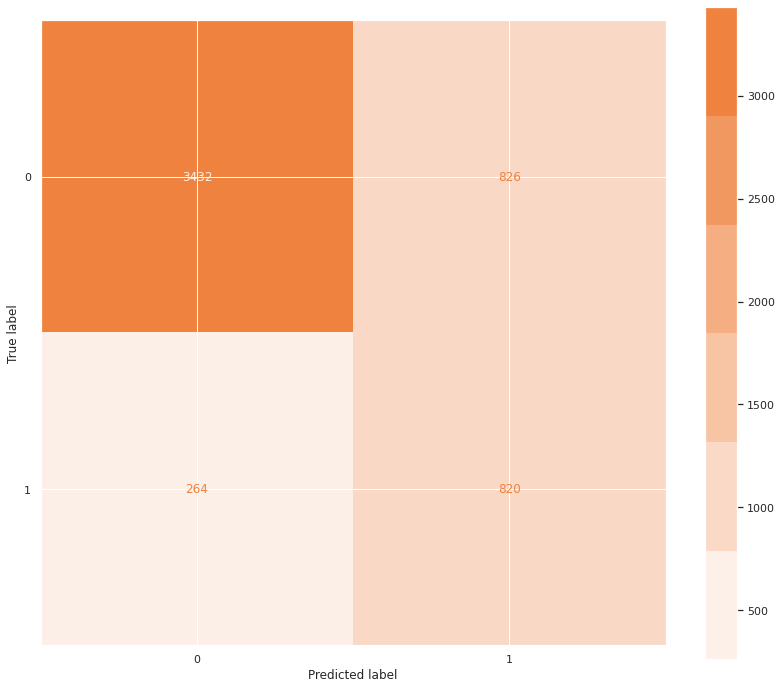

In [29]:
#Logistic Regression: Select Features, Scaled, with Interactions
log_pred1 = logreg4.predict(interactions.get_X_test())

cm = metrics.confusion_matrix(interactions.y_test, log_pred1)
print('Logisitic Regression 2: All Features, Scaled')
print('Confusion Matrix :')
print(cm) 
print('Test Accuracy Score :',metrics.accuracy_score(interactions.y_test, log_pred1))
print('Report : ')
print(classification_report(interactions.y_test, log_pred1))

palette = sns.light_palette("#EE823E")
confusion_matrix_graph(logreg4, interactions.get_X_test(), interactions.y_test, font_scale=1, palette=palette, figsize=(14,12))

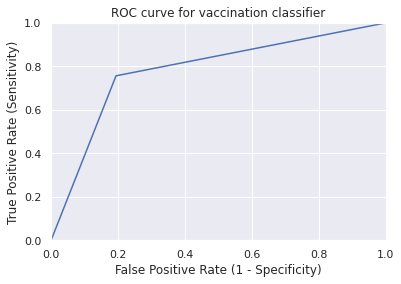

In [30]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(interactions.y_test, log_pred1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for vaccination classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

### Support Vector Machine Model Analysis

Confusion Matrix :
[[4243   15]
 [1063   21]]
Accuracy Score : 0.7982029202545863
Report : 
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      4258
           1       0.58      0.02      0.04      1084

    accuracy                           0.80      5342
   macro avg       0.69      0.51      0.46      5342
weighted avg       0.76      0.80      0.71      5342



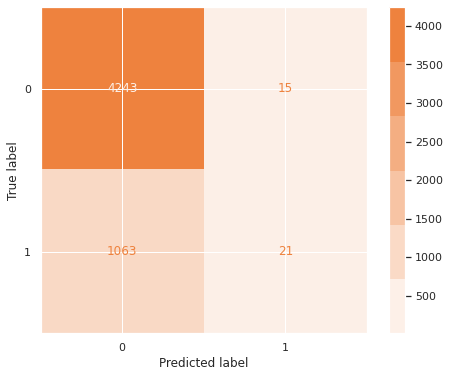

In [31]:
svc_pred1 = svc1.predict(interactions.get_X_test())

cm = metrics.confusion_matrix(interactions.y_test, svc_pred1)
print('Confusion Matrix :')
print(cm) 
print('Accuracy Score :',metrics.accuracy_score(interactions.y_test, svc_pred1))
print('Report : ')
print(classification_report(interactions.y_test, svc_pred1))

palette = sns.light_palette("#EE823E")
confusion_matrix_graph(svc1, interactions.get_X_test(), interactions.y_test, font_scale=1, palette=palette, figsize=(8,6))

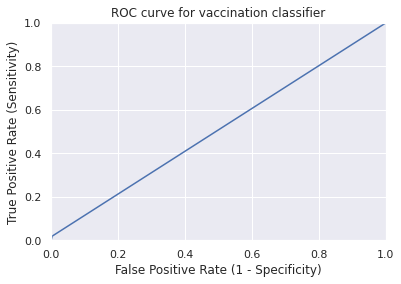

In [32]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(interactions.y_test, svc_pred1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for vaccination classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

### Recommendations